In [17]:
import sys
import os
from os.path import join
sys.path.insert(0, join('/workspace/CenterNet/CenterNet/src/lib'))

from detectors.detector_factory import detector_factory
from models.decode import ctdet_decode
from models.model import create_model
from opts import opts
import torch
import cv2
import matplotlib.pyplot as plt

In [5]:
MODEL_PATH = './models/ctdet_coco_resdcn18.pth' #モデルのパス
TASK = 'ctdet' 
# opt = opts().init('{} --load_model {} --arch resdcn_18 --keep_res --test_scales 1'.format(TASK, MODEL_PATH).split(' '))
opt = opts().init('{} --load_model {} --arch resSpattntion_18 --keep_res --test_scales 1'.format(TASK, MODEL_PATH).split(' '))
detector = detector_factory[opt.task](opt)

Keep resolution testing.
training chunk_sizes: [32]
The output will be saved to  /workspace/CenterNet/CenterNet/src/lib/../../exp/ctdet/default
heads {'hm': 80, 'wh': 2, 'reg': 2}
Creating model...
OrderedDict([('conv1.weight', Parameter containing:
tensor([[[[-1.0419e-02, -6.1356e-03, -1.8098e-03,  ...,  5.6615e-02,
            1.7083e-02, -1.2694e-02],
          [ 1.1083e-02,  9.5276e-03, -1.0993e-01,  ..., -2.7124e-01,
           -1.2907e-01,  3.7424e-03],
          [-6.9434e-03,  5.9089e-02,  2.9548e-01,  ...,  5.1972e-01,
            2.5632e-01,  6.3573e-02],
          ...,
          [-2.7535e-02,  1.6045e-02,  7.2595e-02,  ..., -3.3285e-01,
           -4.2058e-01, -2.5781e-01],
          [ 3.0613e-02,  4.0960e-02,  6.2850e-02,  ...,  4.1384e-01,
            3.9359e-01,  1.6606e-01],
          [-1.3736e-02, -3.6746e-03, -2.4084e-02,  ..., -1.5070e-01,
           -8.2230e-02, -5.7828e-03]],

         [[-1.1397e-02, -2.6619e-02, -3.4641e-02,  ...,  3.2521e-02,
            6.6221e-04

In [35]:
MODEL_PATH = '/workspace/dev/CenterNet/exp/split_att/model_last.pth' #モデルのパス
TASK = 'ctdet' 
# opt = opts().init('{} --load_model {} --arch resdcn_18 --keep_res --test_scales 1'.format(TASK, MODEL_PATH).split(' '))
opt = opts().init('{} --load_model {} --arch resattention --keep_res --test_scales 1'.format(TASK, MODEL_PATH).split(' '))
detector = detector_factory[opt.task](opt)

Keep resolution testing.
training chunk_sizes: [32]
The output will be saved to  /workspace/CenterNet/CenterNet/src/lib/../../exp/ctdet/default
heads {'hm': 80, 'wh': 2, 'reg': 2}
Creating model...
=> loading pretrained model https://github.com/zhanghang1989/ResNeSt/releases/download/weights_step1/resnest101-22405ba7.pth
=> init deconv weights from normal distribution
loaded /workspace/dev/CenterNet/exp/split_att/model_last.pth, epoch 45


In [6]:
detector.model

PoseResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (cbam): CBAM(
        (SpatialGate): SpatialGate(
          (compress): ChannelPool()
          (spatial): BasicConv(
            (conv): Conv2d(2, 1, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
            (bn): BatchN

In [24]:
import numpy as np
np.random.seed(4)
colors = [[np.random.randint(0, 255) for _ in range(3)] for _ in range(80)]

In [13]:
img_path = './kousoku.jpg'

(480, 640, 3)
torch.Size([1, 3, 512, 672])
torch.Size([1, 2048, 16, 21])


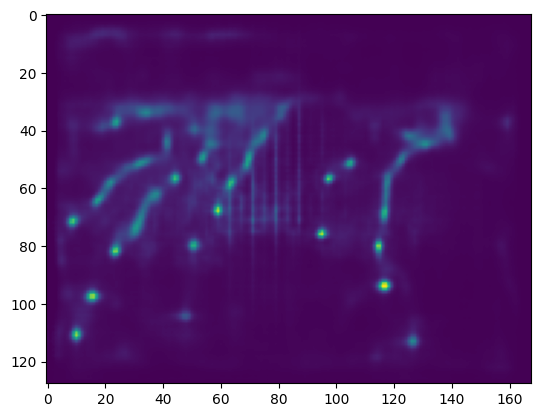

In [36]:
# img_info = coco.loadImgs(imgIds[np.random.randint(0,len(imgIds))])[0]
# img_dir = "/workspace/CenterNet/data/coco/val2017/"
# img = cv2.imread(img_dir+img_info["file_name"])
img = cv2.imread(img_path)
print(img.shape)
pre_img, meta = detector.pre_process(img, 1)
pre_img = pre_img.to(detector.opt.device)
print(pre_img.size())
detections = []
with torch.no_grad():
    output = detector.model(pre_img)[-1]
    hm = output['hm'].sigmoid_()
    wh = output['wh']
    reg = output['reg'] if detector.opt.reg_offset else None
    res = hm.to('cpu').detach().numpy().copy()[0][2]
    plt.imshow(res)
    dets = ctdet_decode(hm, wh, reg=reg, cat_spec_wh=detector.opt.cat_spec_wh, K=detector.opt.K)
    dets = detector.post_process(dets, meta, 1)
    detections.append(dets)
    
results = detector.merge_outputs(detections)

In [37]:
img = cv2.imread(img_path)
for i, ret in results.items():
  for rret in ret:
    if rret[4] > 0.3:
        cv2.rectangle(img, (int(rret[0]), int(rret[1])), (int(rret[2]), int(rret[3])), colors[i], 2)

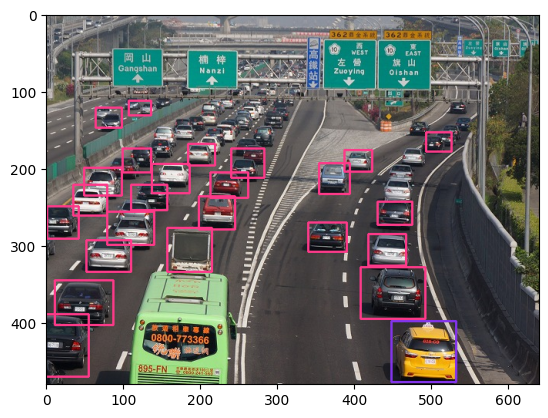

In [38]:
plt.imshow(img[:,:,::-1])

In [2]:
from src.lib.models.networks.ResNeSt.resnest.torch.models.resnest import resnest101

In [12]:
model = resnest101(True)

In [14]:
model.state_dict

<bound method Module.state_dict of ResNet(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2